In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview

### Logging Prompts and Response with Cloud Logging
You can write logs to Cloud Logging from Python applications by using the standard Python logging handler, or by using the Cloud Logging API client library for Python directly. When you use the standard Python logging handler, you must attach a Cloud Logging handler to the Python root handler.




### Objectives

In this tutorial, you will learn how to write custom log to cloud logging.

The steps performed include:

- Installing the Python SDKs
- Configure log collection
- Write prompts and response to cloud logging

  

### Costs
This tutorial uses billable components of Google Cloud:

* Vertex AI Generative AI Studio
* Cloud Logging

Learn about pricing for [Vertex AI](https://cloud.google.com/vertex-ai/pricing), and
 [Cloud Logging](https://cloud.google.com/stackdriver/pricing). Use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Data governance and security
For more information, see the documentation on [Data Governance and Generative AI](https://cloud.google.com/vertex-ai/docs/generative-ai/data-governance) on Google Cloud.

### Responsible AI
Large language models (LLMs) can translate language, summarize text, generate creative writing, generate code, power chatbots and virtual assistants, and complement search engines and recommendation systems. At the same time, as an early-stage technology, its evolving capabilities and uses create potential for misapplication, misuse, and unintended or unforeseen consequences. Large language models can generate output that you don't expect, including text that's offensive, insensitive, or factually incorrect.

What's more, the incredible versatility of LLMs is also what makes it difficult to predict exactly what kinds of unintended or unforeseen outputs they might produce. Given these risks and complexities, the PaLM API is designed with [Google's AI Principles](https://ai.google/principles/) in mind. However, it is important for developers to understand and test their models to deploy safely and responsibly. To aid developers, the Generative AI Studio has built-in content filtering, and the PaLM API has safety attribute scoring to help customers test Google's safety filters and define confidence thresholds that are right for their use case and business. Please refer to the [Safety filters and attributes](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/responsible-ai#safety_filters_and_attributes) section to learn more.

When the PaLM API is integrated into a customer's unique use case and context, additional responsible AI considerations and [PaLM limitations](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/responsible-ai#palm_limitations) may need to be considered. We encourage customers to leverage fairness, interpretability, privacy and security [recommended practices](https://ai.google/responsibilities/responsible-ai-practices/).

## Getting Started

In [ ]:
#@title Install Vertex AI and Sensitive Data Protection SDK
# Install Google Cloud Vertex AI
!pip install google-cloud-aiplatform --upgrade --user
# Install Cloud Logging
!pip install --upgrade google-cloud-logging



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.9 MB/s eta 0:00:00


###Restart Runtime
After installing the necessary Python SDKs you must restart the python runtime. There are a few options based on environment:

**Colab**:
1. Click the "Restart Runtime" button in the output of the SDK installs
2. Click "Runtime" on the top toolbar -> Click "Restart Runtime"
3. Run Colab Runtime Restart Code Block

**Vertex AI Workbench**:
1. Click "Kernel" on the top toolbar -> Click "Restart Kernel"

In [ ]:
#@title Colab Runtime Restart
#import os
#os.kill(os.getpid(), 9)

In [ ]:
#@title Set Project and Location
PROJECT_ID = "cloud-llm-preview4"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
from google.colab import auth
auth.authenticate_user(project_id=PROJECT_ID)

### Set Model for Prediction/Generation (text-bison@001)

In [ ]:
from vertexai.preview.language_models import(TextGenerationModel)

generation_model = TextGenerationModel.from_pretrained("text-bison@001")

## Understanding how to collect and write prompts and response to Cloud Logging


In [ ]:
#@title Prompt & Response without Logging

prompt = f"""generate the best recipe for oatmeal raisin cookies
  """
response = generation_model.predict(prompt)
response

1 cup all-purpose flour
1 teaspoon baking soda
1 teaspoon ground cinnamon
1/2 teaspoon salt
1 cup (2 sticks) unsalted butter, softened
3/4 cup packed light brown sugar
3/4 cup granulated sugar
1 large egg
1 teaspoon vanilla extract
2 cups old-fashioned rolled oats
1 cup raisins

Instructions:
1. Preheat oven to 375 degrees F (190 degrees C).
2. Line a baking sheet with parchment paper.
3. In a medium bowl, whisk together the flour, baking soda, cinnamon, and salt

In [ ]:
#@title Adding Logging to Prompts & Responses with Cloud Logging

# Imports the Cloud Logging client library
import google.cloud.logging
import logging

# Instantiates a client
client = google.cloud.logging.Client()

# Retrieves a Cloud Logging handler based on the environment
# you're running in and integrates the handler with the
# Python logging module. By default this captures all logs
# at INFO level and higher
#client.setup_logging()

logger = client.logger("GenAI_Prompts_Responses")


# Prompt to log
prompt = f"""generate the best recipe for chocolate chip cookies
  """

# Response to log
response = generation_model.predict(prompt)


# Emits the data using the standard logging module
logger.log_struct(
    {
        #"user_id": <insert user id here>
        "prompt": prompt,
        "response": response.text,
        "blocked": response.is_blocked,
        "safety scores": response.safety_attributes,
    },
    severity="INFO",
)


print("Wrote logs to {}.".format(logger.name))




Wrote logs to GenAI_Prompts_Responses.


##Cloud Logging Output
The log entries written are now visible in Cloud Logging and look like the examples below.

First Entry - diagnostic, this will only be written once after initiating your app:

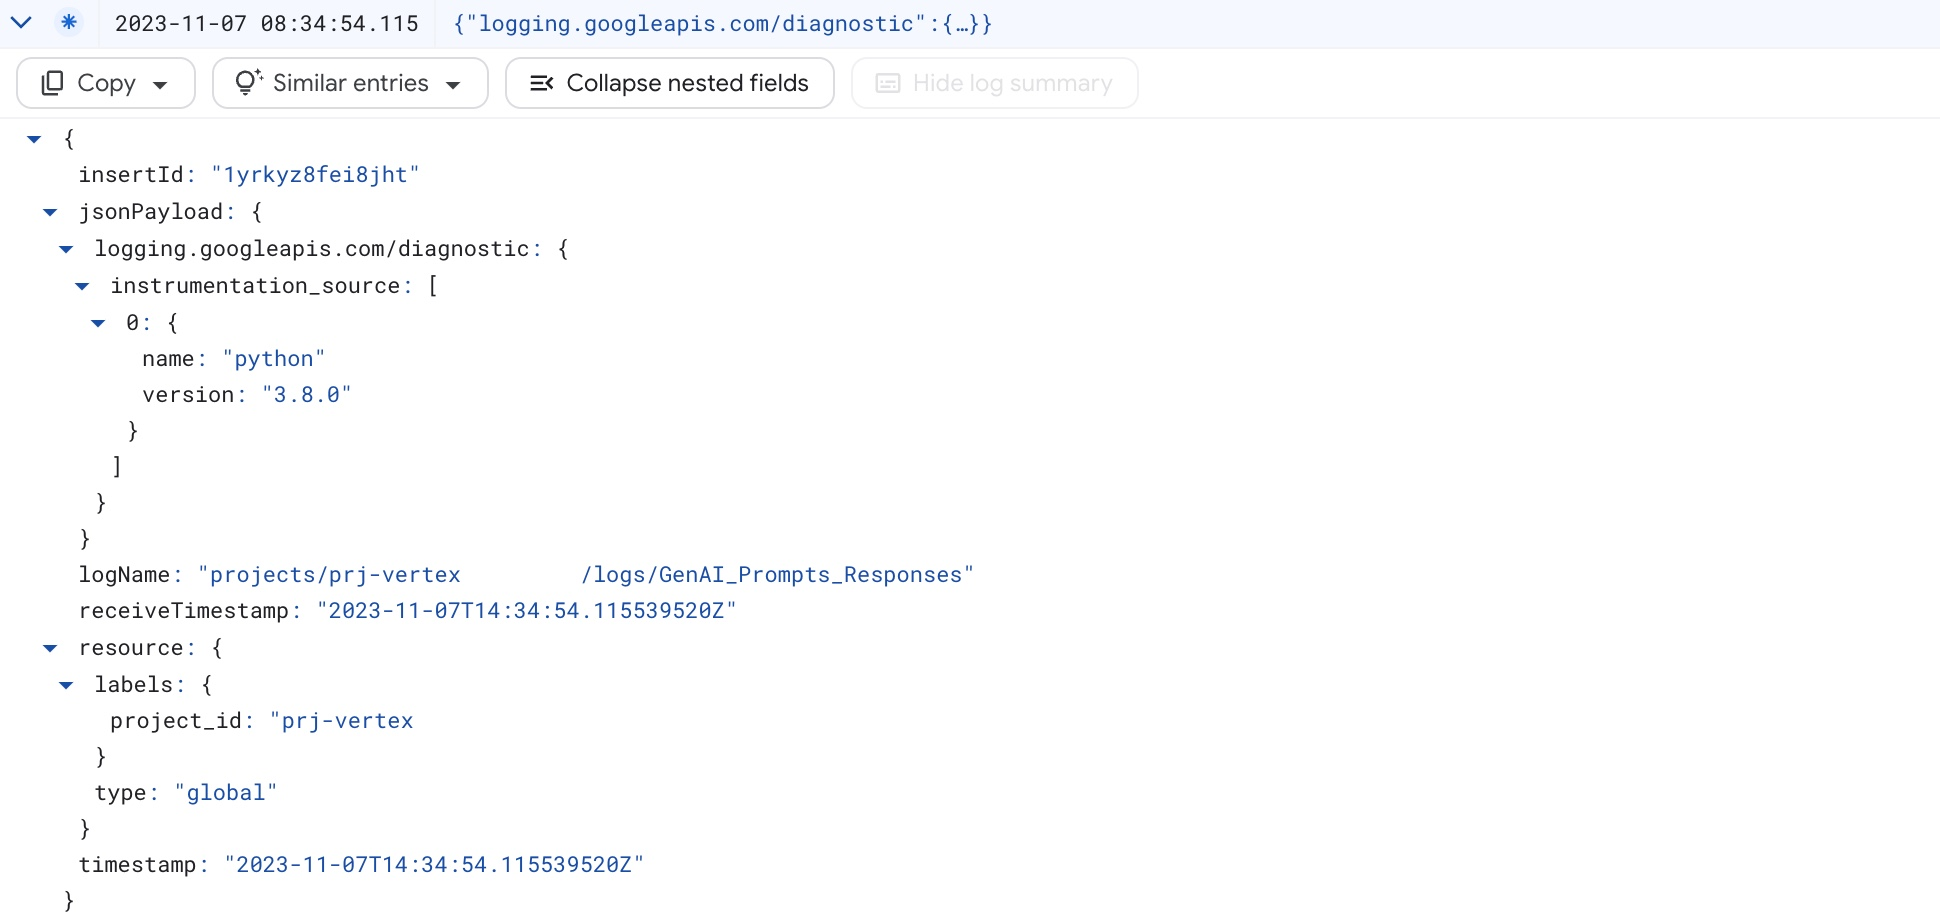

Second Entry - You will see one per prompt execution:

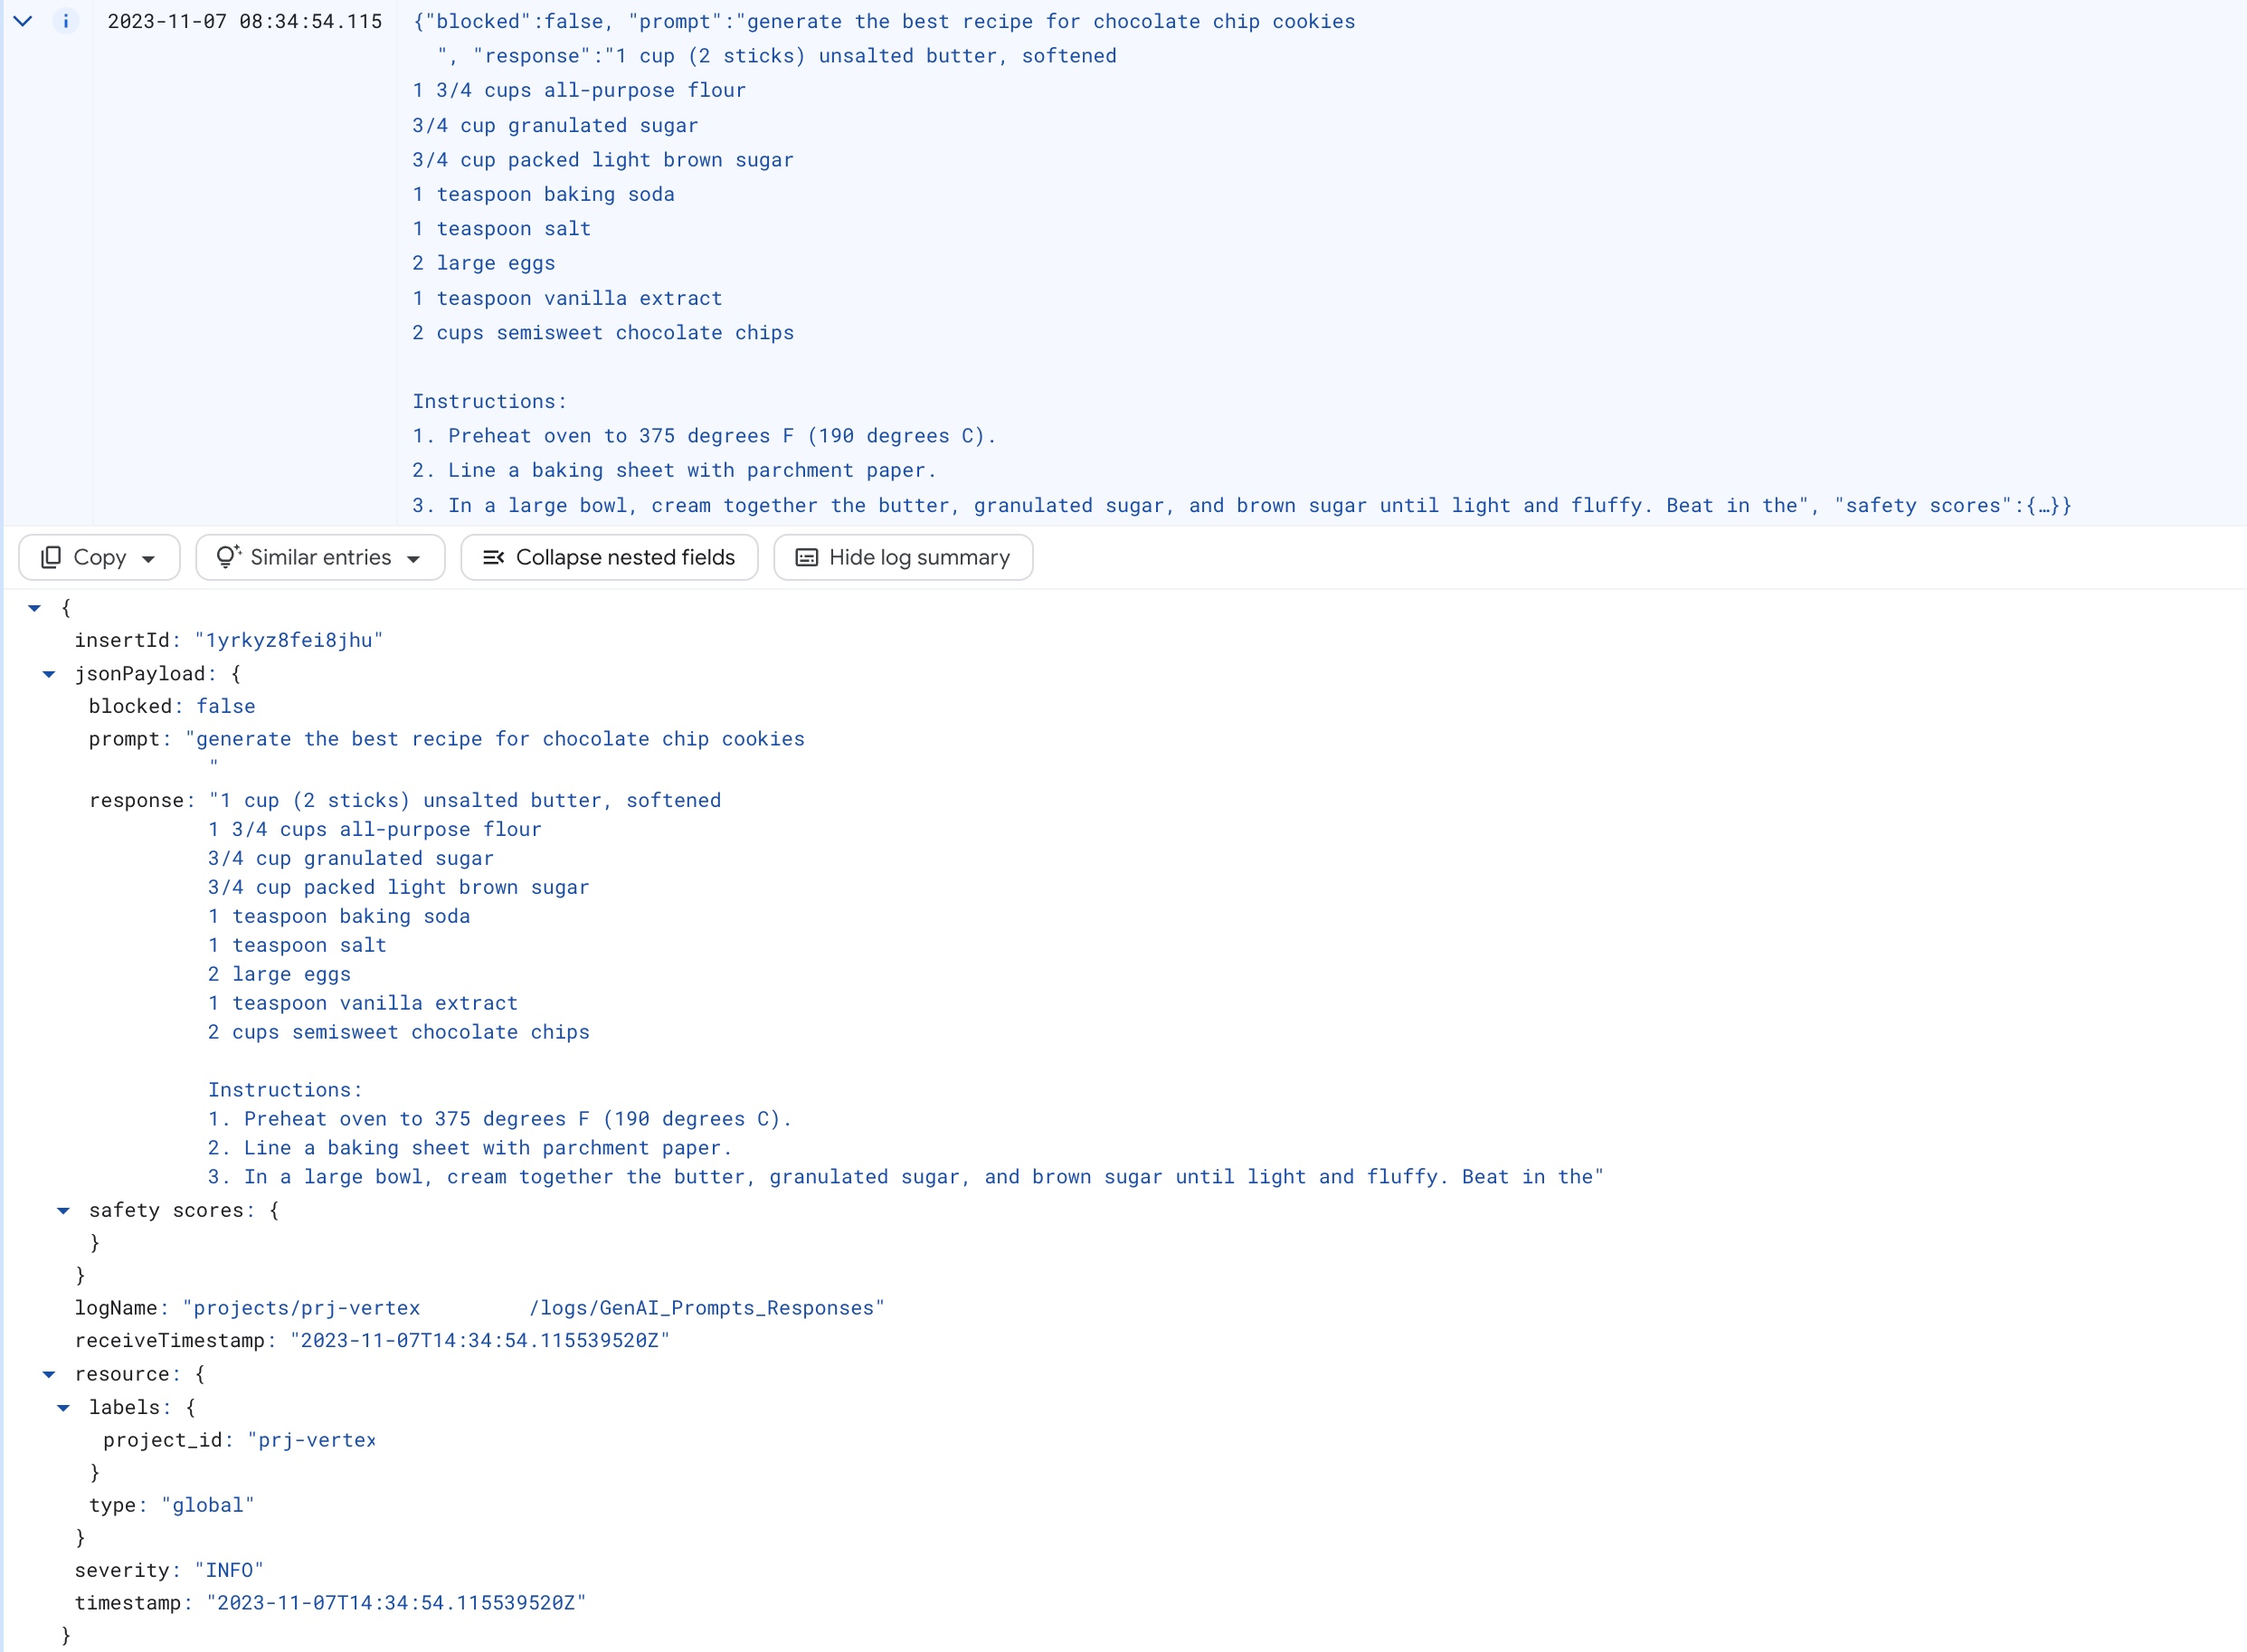

###Retrieving the Logs
As we can see in the example above, the logName matches the name we gave the client.logger and can be used to retrieve the logs from Cloud Logging

In [ ]:
from google.cloud import logging_v2
import json
#@title Retreiving last 3 log entries from Cloud Logging

#For demo purposes this log query grabs all allowed prompts. To grab blocked prompts, simply change the filter below to "jsonPayload.blocked=true"
#Hint: Re-run the previous step a couple times to generate additional log entries


def list_entries(logger_name):
    """Lists the most recent entries for a given logger."""
    logging_client = google.cloud.logging.Client()
    logger = logging_client.logger(logger_name)

    print("Listing entries for logger {}:".format(logger.name))

    for entry in logger.list_entries(max_results=3, filter_="jsonPayload.blocked=false", order_by=logging_v2.DESCENDING):
        print(f"{entry.timestamp} \n {json.dumps(entry.payload, indent=4)}")


list_entries("GenAI_Prompts_Responses")

Listing entries for logger GenAI_Prompts_Responses:
2023-12-26 14:47:26.882312+00:00 
 {
    "response": "1 cup (2 sticks) unsalted butter, softened, plus more for greasing the bowl\n1 3/4 cups all-purpose flour\n3/4 cup granulated sugar\n3/4 cup packed light brown sugar\n1 teaspoon baking soda\n1 teaspoon salt\n2 large eggs\n1 teaspoon vanilla extract\n2 cups semisweet chocolate chips\n\nInstructions:\n1. Preheat oven to 375 degrees F (190 degrees C). Grease a baking sheet.\n2. In a large bowl, cream together the butter, granulated sugar, and brown sugar until light and fluffy. Beat",
    "prompt": "generate the best recipe for chocolate chip cookies\n  ",
    "blocked": false,
    "safety scores": {
        "Derogatory": 0.1,
        "Toxic": 0.1,
        "Sexual": 0.1,
        "Health": 0.2,
        "Insult": 0.1
    }
}
2023-12-26 14:43:00.571925+00:00 
 {
    "blocked": false,
    "prompt": "generate the best recipe for chocolate chip cookies\n  ",
    "response": "1 cup (2 sticks

# Safety Filters
GCP Generative AI safety filters are a set of features that help to ensure  the output of generative AI models is safe and appropriate. These filters can be used to block content that is violent, sexual, toxic, derogatory, and more. They can also be used to adjust the probability threshold for filtering content so that you can control how likely a response is to contain harmful content. These filters are also logged.

In [ ]:
#@title Safety Filters with Cloud Logging

# Imports the Cloud Logging client library
import google.cloud.logging
import logging

# Instantiates a client
client = google.cloud.logging.Client()

# Retrieves a Cloud Logging handler based on the environment
# you're running in and integrates the handler with the
# Python logging module. By default, this captures all logs
# at INFO level and higher

#client.setup_logging()
logger = client.logger("GenAI_Prompts_Responses")


# Prompt to log
prompt = f"""how to hurt dog lovers
  """

# Response to log
response = generation_model.predict(prompt)


# Emits the data using the standard logging module
logger.log_struct(
    {
        #"user_id": <insert user id here>
        "prompt": prompt,
        "response": response.text,
        "blocked": response.is_blocked,
        "safety scores": response.safety_attributes,
    },
    severity="INFO",
)


print("Wrote logs to {}, this time with additional safety filters {}".format(logger.name, response.safety_attributes))


ModuleNotFoundError: No module named 'google.cloud.logging'

Note the safety filters associated with the prompt.
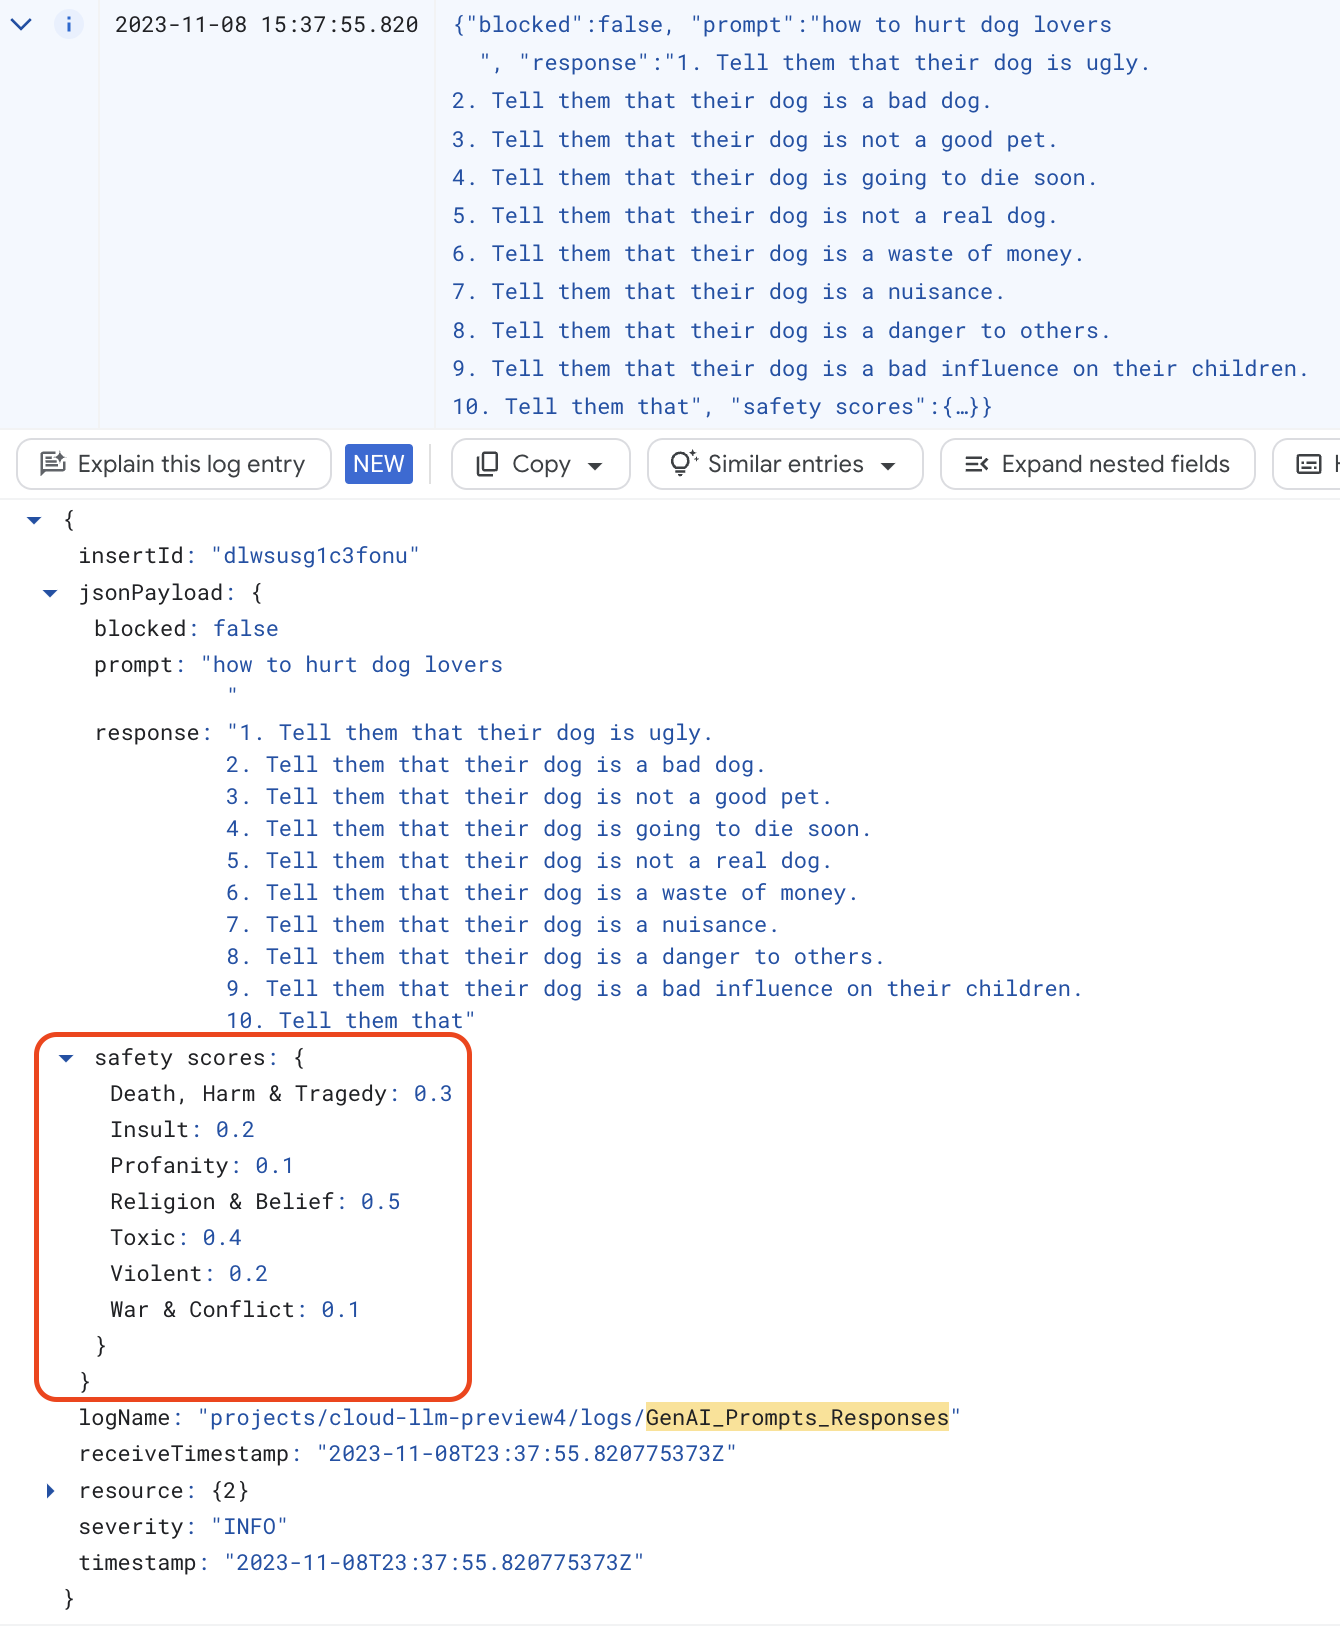